In [16]:
from tensorflow.python.keras.utils import get_file
import gzip
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
import functools
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"  # 使用第3块显卡

## 读取数据与数据预处理

In [17]:
# 数据集和代码放一起即可
def load_data():
    paths = [
        'train-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz',
        't10k-labels-idx1-ubyte.gz', 't10k-images-idx3-ubyte.gz'
    ]

    with gzip.open(paths[0], 'rb') as lbpath:
        y_train = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(paths[1], 'rb') as imgpath:
        x_train = np.frombuffer(
            imgpath.read(), np.uint8, offset=16).reshape(len(y_train), 28, 28, 1)

    with gzip.open(paths[2], 'rb') as lbpath:
        y_test = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(paths[3], 'rb') as imgpath:
        x_test = np.frombuffer(
            imgpath.read(), np.uint8, offset=16).reshape(len(y_test), 28, 28, 1)
    return (x_train, y_train), (x_test, y_test)


In [18]:
(x_train, y_train), (x_test, y_test) = load_data()
batch_size = 32
num_classes = 10
epochs = 5
data_augmentation = True  # 图像增强
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models_cnn')
model_name = 'keras_fashion_trained_model.h5'

In [19]:
# Convert class vectors to binary class matrices. 类别独热编码
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255  # 归一化
x_test /= 255  # 归一化

## 搭建传统CNN模型

In [11]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',  # 32，(3,3)是卷积核数量和大小
                 input_shape=x_train.shape[1:]))  # 第一层需要指出图像的大小
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

## 训练

In [12]:
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)
    print(x_train.shape[0]//batch_size)  # 取整
    print(x_train.shape[0]/batch_size)  # 保留小数
    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(x_train, y_train,  # 按batch_size大小从x,y生成增强数据
                                     batch_size=batch_size),  
                        # flow_from_directory()从路径生成增强数据,和flow方法相比最大的优点在于不用
                        # 一次将所有的数据读入内存当中,这样减小内存压力，这样不会发生OOM
                        epochs=epochs,
                        steps_per_epoch=x_train.shape[0]//batch_size,
                        validation_data=(x_test, y_test),
                        workers=10  # 在使用基于进程的线程时，最多需要启动的进程数量。
                       )

Using real-time data augmentation.
1875
1875.0
Epoch 1/5
1875/1875 [==============================] - 187s 100ms/step - loss: 0.9836 - acc: 0.6374 - val_loss: 0.6204 - val_acc: 0.7603
Epoch 2/5
1875/1875 [==============================] - 186s 99ms/step - loss: 0.6752 - acc: 0.7419 - val_loss: 0.5404 - val_acc: 0.7965
Epoch 3/5
1875/1875 [==============================] - 205s 109ms/step - loss: 0.5921 - acc: 0.7764 - val_loss: 0.4921 - val_acc: 0.8159
Epoch 4/5
1875/1875 [==============================] - 193s 103ms/step - loss: 0.5368 - acc: 0.8000 - val_loss: 0.4262 - val_acc: 0.8440
Epoch 5/5
1875/1875 [==============================] - 194s 104ms/step - loss: 0.4958 - acc: 0.8145 - val_loss: 0.4366 - val_acc: 0.8448


## 模型可视化与保存模型

In [13]:
model.summary()
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
activation_7 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        18496     
__________

## 训练过程可视化

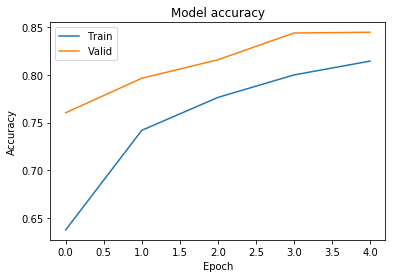

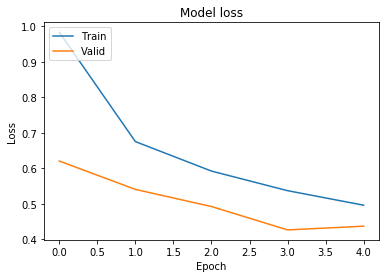

In [15]:
import matplotlib.pyplot as plt
# 绘制训练 & 验证的准确率值
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.savefig('tradition_cnn_valid_acc.png')
plt.show()

# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.savefig('tradition_cnn_valid_loss.png')
plt.show()